## notebook for training a RealNVP on the encoded data distribution 

In [10]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

1.15.0


In [11]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [12]:
#from pae import model
from pae.model import get_prior, get_posterior, get_likelihood

In [13]:
import pae.create_datasets as crd

#### specify the parameter file (the only required changes are the latent dim 4<->8,16,32 and the loss AE<->VAE_comp_AE)

In [14]:
param_file   = 'params_fmnist_-1_32_infoGAN_AE_full_sigma'
PROJECT_PATH = "../../" 
PARAMS_PATH  = os.path.join(PROJECT_PATH,'params')

In [15]:
params   = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [16]:
if not os.path.isdir(params['plot_dir']):
    os.makedirs(params['plot_dir'])
if not os.path.isdir(params['data_dir']):
    os.makedirs(params['data_dir'])

In [48]:
params['data_dir']

'../data'

In [26]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nvp')

#### The RealNVP depth and shift parameter depend on latent dimensionality:
latent dim 4: 8, 4  
latent dim 8: 10, 4  
latent dim 16: 12, 4  
latent dim 32: 18, 10   

In [27]:
nvp_depth    = 8
shift        = 4
indices      = np.arange(params['latent_size'])
permutations = [np.random.permutation(indices) for ii in range(nvp_depth)]

In [28]:
train_input_fn, eval_input_fn = crd.build_input_fns(params,label=params['class_label'],flatten=False,num_repeat=15)

loading fmnist dataset


Train or load trained module?

In [29]:
train = False

In [ ]:
tf.reset_default_graph()

lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(params['batch_size'],shape=[])
data          = train_input_fn()
validdata     = eval_input_fn()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params)

# inspect the model
z_    = posterior(validdata).mean()
recon = likelihood(z_).mean()
prior_sample = prior.sample(sample_size)
x_old   = likelihood(prior_sample).mean()

# ### ----------- NVP ----------- ###
def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)


nvp_size      = [[32,32] for ii in range(nvp_depth)]


def get_nvp():
    base_dis = get_prior(params['latent_size'])
    chain    = []
  
    perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
  
    for i,s in enumerate(nvp_size):
        if i%2==0:
            chain.append(perms[i])
        if i<shift:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i, shift_only=True)))
        else:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    chain.append(perms[i])

    nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample}\
                      ,outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass, 'bwd_pass': nvp_bwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
if train:
    nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
else: 
    nvp_funcs     = hub.Module(nvp_path, trainable=False)
    
z         = posterior(data).mean()
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

if train:
    opt_op_nvp= optimizer.minimize(loss)

z_valid   = posterior(validdata).mean()
loss_valid= -tf.reduce_mean(nvp_funcs({'z_sample':z_valid,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])
nvp_encoded_valid = -tf.reduce_mean(nvp_funcs({'z_sample':z_valid,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'])
nvp_encoded_train = -tf.reduce_mean(nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['bwd_pass'])


nvp_sample= nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new     = likelihood(nvp_sample).mean()
 
# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#### reconstructions and samples before fit

In [32]:
rec, d   = sess.run([recon,validdata])
x_sample = sess.run(x_old)

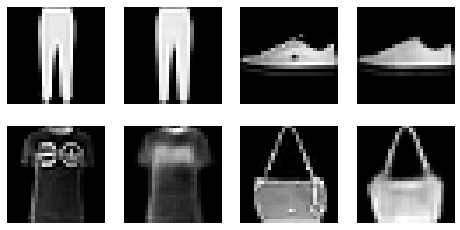

In [33]:
#reconstructions
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(4):
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((d[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')
    jj+=1
    plt.subplot(2,4,jj)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')
    jj+=1


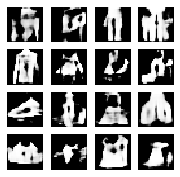

In [34]:
# samples
plt.figure(figsize=(3,3))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((x_sample[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')

#### to get a crude idea: compare latent space distribution of data with prior 

In [35]:
z_sample=[]
z_sample_valid=[]
for ii in range(100):
    z_sample+=[sess.run(z)]
for ii in range(100):
    z_sample_valid+=[sess.run(z_valid)]
z_sample=np.asarray(z_sample).reshape((-1,params['latent_size']))
z_sample_valid=np.asarray(z_sample_valid).reshape((-1,params['latent_size']))
print(z_sample.shape, z_sample_valid.shape)

prior_s = sess.run(prior_sample,feed_dict={sample_size:100*params['batch_size']})

(12800, 32) (12800, 32)


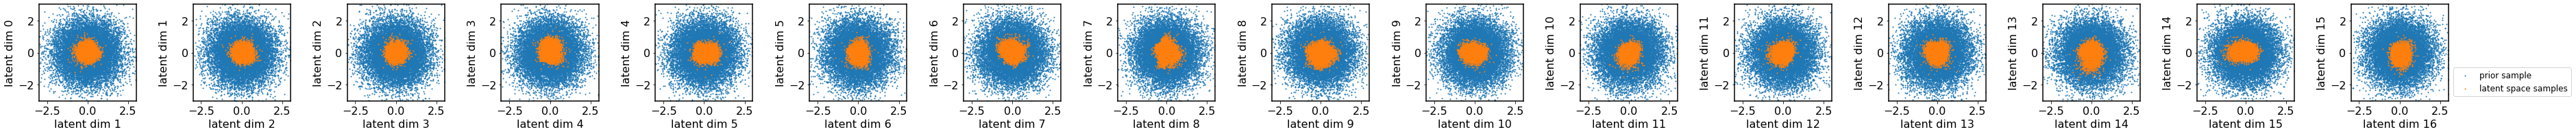

In [37]:
red = 16
plt.figure(figsize=((params['latent_size']-red)*3+2,3))
for nn in range(params['latent_size']-red):
    plt.subplot(1,params['latent_size']-red,nn+1)
    plt.scatter(prior_s[:,nn],prior_s[:,nn+1],s=1, label='prior sample') 
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=1, label='latent space samples') 
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()
    plt.xlim(-3,3)
    plt.ylim(-3,3)
plt.legend(loc=(1.05,0.05))
plt.show()

### Train the realNVP

In [ ]:
nvp_loss = []
nvp_vloss = []

In [ ]:
if train:
    ii     = 0
    learning_rate = 2e-3

    #train the nvp for 100 epochs
    while ii<(100*50000)//params['batch_size']:
        _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate})
        nvp_loss+=[ll]
        if ii%200==0:
            l_ = sess.run(loss_valid,  feed_dict={lr: learning_rate})
            print(np.mean(nvp_loss[-100::]),l_)
            nvp_vloss+=[l_]
        if ii == (50*50000):
            print('reducing learning rate')
            learning_rate=1e-4
        ii+=1

In [ ]:
#plot the loss function
plt.figure()
plt.plot(np.convolve(nvp_loss[::],np.ones((100))/100., mode='valid'),label='training loss (smoothed)')
plt.plot(np.arange(0,len(nvp_vloss)*197,200),np.convolve(nvp_vloss,np.ones((3))/3., mode='valid'),label='validation loss' )
plt.xlabel('# iteration')
plt.ylabel('RealNVP loss')
plt.legend()
plt.ylim(-22,8)
plt.savefig(os.path.join(params['plot_dir'],'RealNVP_loss.pdf'),bbox_inches='tight')

#### compare samples before and after realNVP fit with reconstructions

In [38]:
s_no_nvp, s_nvp = sess.run([x_old,x_new])
z_sample_nvp    = sess.run(nvp_sample,feed_dict={sample_size:100*params['batch_size']})

## AE and PAE plots in Fig. 2. 

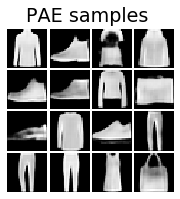

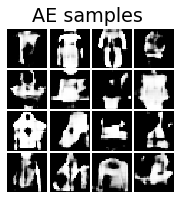

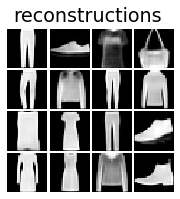

In [46]:
plt.figure(figsize=(3,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
plt.suptitle('PAE samples')
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_nvp[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'NVP_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(3,3))
plt.suptitle('AE samples')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((s_no_nvp[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()
plt.figure(figsize=(3,3))
plt.suptitle('reconstructions')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(np.squeeze((rec[ii]+0.5).reshape(params['width'],params['height'],-1)),cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'reconstructions.pdf'),bbox_inches='tight')
plt.show()

#### compare the distribution of realNVP samples with encoded data distribution

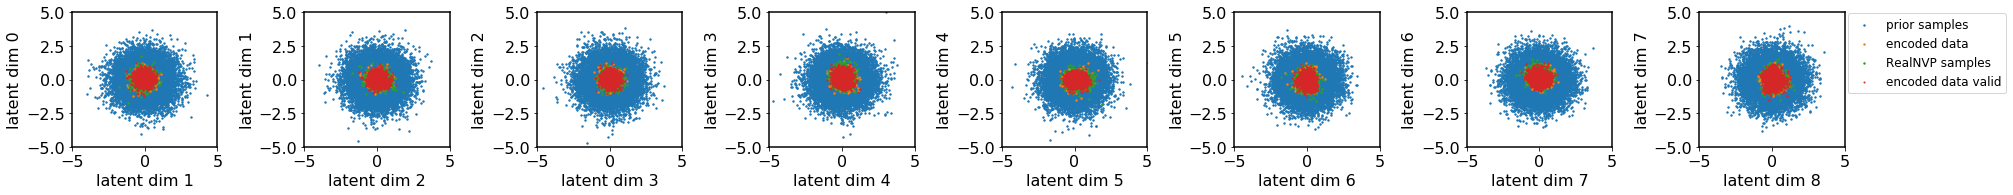

In [42]:
red = 24
plt.figure(figsize=((params['latent_size']-red)*3+2,3))
for nn in range(params['latent_size']-red):
    plt.subplot(1,params['latent_size']-red,nn+1)
    plt.scatter(prior_s[:,nn],prior_s[:,nn+1],s=2, label='prior samples') 
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=2, label='encoded data')  
    plt.scatter(z_sample_nvp[:,nn],z_sample_nvp[:,nn+1],s=2, label='RealNVP samples') 
    plt.scatter(z_sample_valid[:,nn],z_sample_valid[:,nn+1],s=1, label='encoded data valid')
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()
    plt.xlim(-5,5)
    plt.ylim(-5,5)
plt.legend(loc=(1.02,0.4))
plt.savefig(os.path.join(params['plot_dir'],'latent_space_samples.pdf'),bbox_inches='tight')

#### save the realNVP model as a module

In [ ]:
if not os.path.isdir(nvp_path):
    os.makedirs(nvp_path)
nvp_funcs.export(nvp_path,sess)

In [ ]:
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))